In [2]:
import os

from typing import Union, Any, Dict, List, Optional

import json
import numpy as np
import pandas as pd
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib

sns.set_palette("colorblind")

plt.rcParams.update({"text.usetex": True})
plt.rcParams['font.size'] = 12

axes_font_size = 18


In [3]:
font_size = 14
legend_font_size = 12
axis_font = {'size': axes_font_size}

In [4]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

In [5]:
def get_results_path(folder_name: Union[str, Path] = 'LRGB_RESULTS') -> Path:
    return Path('RESULTS') / folder_name

In [6]:
def get_plots_path() -> Path:
    return Path('images')

In [7]:
def load_object(file_name: Union[str, Path]) -> Dict[Any, Any]:
    file_name = Path(file_name)
    file = open(file_name, 'r')
    return json.load(file)

In [8]:
filter_names_dict = {'input_features': 'Input-Based Filter',
                     'embedding-no-weight-sharing': 'Embedding-Based Filter',
                     'none': 'No Filtering'}
    
methods_dict = {'udn': r'$\textsc{AMP}_\textsc{UDN}$',
                'adgn': r'$\textsc{AMP}_\textsc{ADGN}$',
                'gin': r'$\textsc{AMP}_\textsc{GIN}$',
                'gcn': r'$\textsc{AMP}_\textsc{GCN}$',
                'gine': r'$\textsc{AMP}_\textsc{GINE}$',
                'gatedgcn': r'$\textsc{AMP}_\textsc{GatedCGN}$'}

tasks_dict = {'SSSP': 'SSSP',
              'Diameter': 'Diameter',
              'Eccentricity': 'Eccentricity',
              'peptides-func': 'peptides-func',
              'peptides-struct': 'peptides-struct'}

metrics_dict = {'avg_validation_score': 'Valid. Score'}

In [9]:
class ExperimentResults:
    def __init__(self, 
                 results_dict: Dict[Any, Any],
                 **config: Any):
        self.results_dict = results_dict
        self.task_names = [task_name for task_name in self.results_dict.keys()]
    
    def get_filter_results(self, metric_name: str = 'avg_validation_loss') -> Dict[str, np.ndarray]:
        filter_results = {}
        for task_name in self.task_names:
            filter_results[task_name] = {} 
            for config in self.results_dict[task_name]:
                if self.results_dict[task_name][config]['filter_messages'] not in filter_results[task_name].keys():
                    filter_results[task_name][self.results_dict[task_name][config]['filter_messages']] = [self.results_dict[task_name][config][metric_name]]
                else:
                    filter_results[task_name][self.results_dict[task_name][config]['filter_messages']].append(self.results_dict[task_name][config][metric_name])
        
        for task_name in self.task_names:
            for filter_name in filter_results[task_name]:
                filter_results[task_name][filter_name] = np.array(filter_results[task_name][filter_name])
        
        return ExperimentResults(filter_results)
    
    @staticmethod
    def load(task_names: List[str],
             folder_name: Union[str, Path] = 'UDN_RESULTS') -> 'ExperimentResults':
        
        all_results = {}
        
        for task_name in task_names:
            task_results = {}
            
            results_path = Path(get_results_path(folder_name)) / task_name / 'MODEL_ASSESSMENT/OUTER_FOLD_1/MODEL_SELECTION'
            config_paths = os.listdir(results_path)
            
            for config_path in config_paths:
                
                if not os.path.isdir(results_path / config_path):
                    continue
                
                config_results_raw = load_object(results_path / config_path / 'config_results.json')
                config_results = {}
                
                for parameter_name, parameter_val in config_results_raw['config']['supervised_config'].items():
                    if parameter_val is None:
                        parameter_val = 'none'
                    if isinstance(parameter_val, dict):
                        if parameter_name == 'truncated_distribution':
                            pass
                    elif isinstance(parameter_val, str):
                        config_results[parameter_name] = parameter_val.split('.')[-1]
                    else:
                        config_results[parameter_name] = parameter_val
                            
                del config_results_raw['config']
                del config_results_raw['folds']
                
                for metric_name, metric_val in config_results_raw.items():
                    config_results[metric_name] = metric_val
                
                task_results[config_path] = config_results
            all_results[task_name] = task_results
        return ExperimentResults(all_results)

Plot results for the Diameter, SSSP, and Eccentricity datasets:

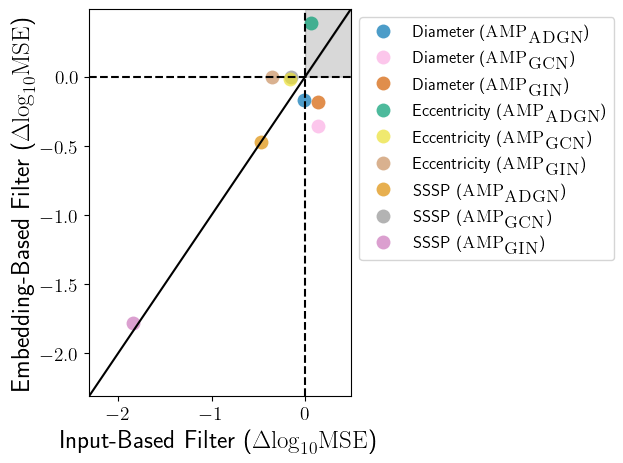

In [82]:
experiment_results = ExperimentResults.load(['udn_adgn_Diameter', 'udn_adgn_SSSP', 'udn_adgn_Eccentricity',
                                             'udn_gin_Diameter', 'udn_gin_SSSP', 'udn_gin_Eccentricity',
                                             'udn_gcn_Diameter', 'udn_gcn_SSSP', 'udn_gcn_Eccentricity'],
                                            folder_name='UDN_RESULTS')

file_name = 'correlation_between_methods'

sns.color_palette('colorblind')

filter_results = experiment_results.get_filter_results('avg_validation_score')

task_names = [task_name for task_name in filter_results.results_dict]
filter_names = [filter_name for filter_name in filter_results.results_dict[task_names[0]] if filter_name != 'none']

task_names_dict = {}
task_names_dict = {task_name: f'{tasks_dict[task]} ({methods_dict[method2]})' for task_name in task_names for method1, method2, task in [task_name.split('_')]}

fig, ax = plt.subplots(1, 1)

results = {filter_name: {task_name: np.min(filter_results.results_dict[task_name][filter_name]) for task_name in task_names} for filter_name in filter_names + ['none']}

max_result = 0.0
min_result = 0.0
alpha = 0.7
markersize = 10

k = 0
for task_name in task_names:
    result_x = results[filter_names[0]][task_name] - results['none'][task_name]
    result_y = results[filter_names[1]][task_name] - results['none'][task_name]
    max_result = np.max([result_x, result_y, max_result])
    min_result = np.min([result_x, result_y, min_result])
    ax.plot(result_x, result_y, 'o', alpha=alpha, label=task_names_dict[task_name], markersize=markersize, markeredgewidth=0.0)
    k += 1

ax.set_xlabel(filter_names_dict[filter_names[0]] + '~($\Delta \mathrm{log}_{10}\mathrm{MSE}$)', **axis_font)
ax.set_ylabel(filter_names_dict[filter_names[1]] + '~($\Delta \mathrm{log}_{10}\mathrm{MSE}$)', **axis_font)

factor = 1.25
min_result *= factor
max_result *= factor

ax.plot([min_result, max_result], [min_result, max_result], 'k-')
ax.plot([min_result, max_result], [0.0, 0.0], 'k--')
ax.plot([0.0, 0.0], [min_result, max_result], 'k--')
ax.fill_between([0, max_result], 0, [0, max_result], color='grey', alpha=0.3)
ax.fill_between([0, max_result], max_result, [0, max_result], color='grey', alpha=0.3)

ax.set_xlim(min_result, max_result)
ax.set_ylim(min_result, max_result)

ax.tick_params(axis='both', which='major', labelsize=font_size)

handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))

plt.legend(handles, labels, bbox_to_anchor=(1.0, 1.0), ncol=1, frameon=True, fontsize=legend_font_size)

plt.tight_layout()
fig.patch.set_alpha(0)

new_file_name = file_name + '.pdf'
plot_name = Path(get_plots_path()) / new_file_name
plt.savefig(plot_name)

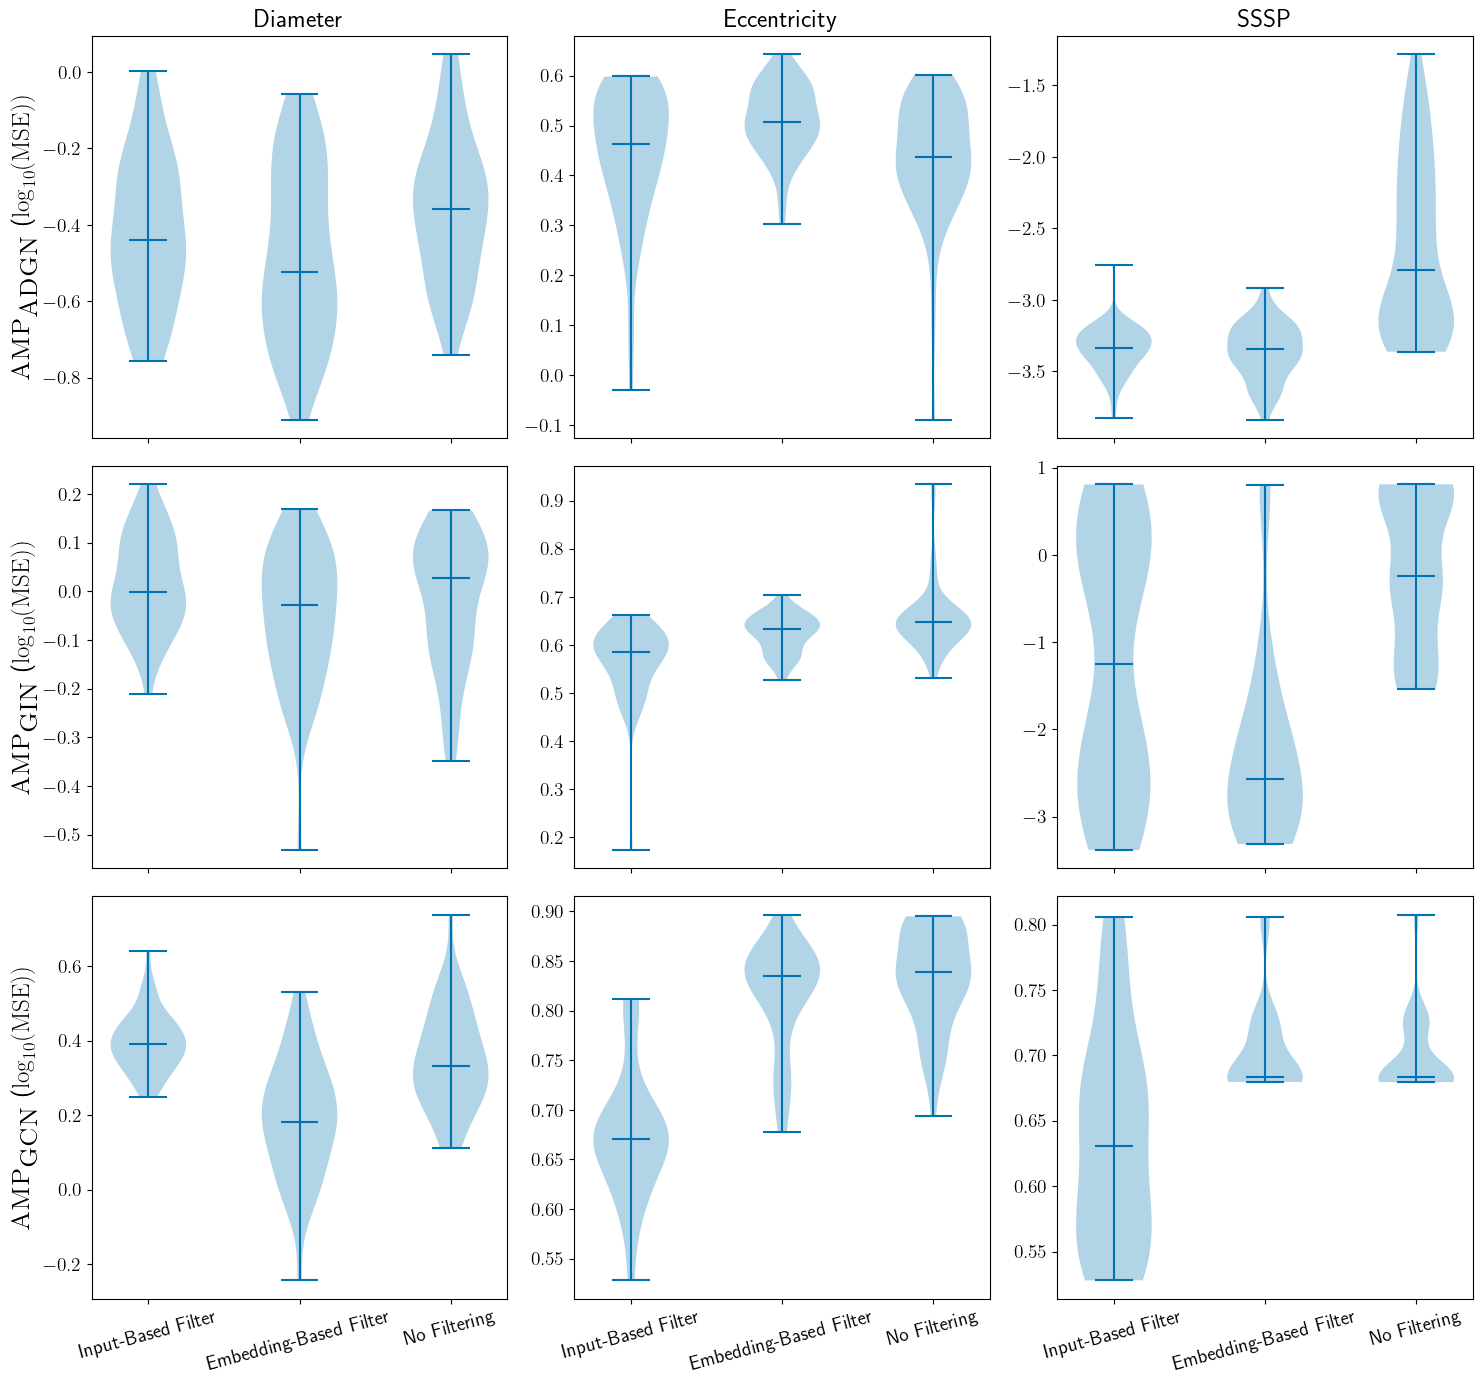

In [74]:
sns.color_palette('colorblind')

file_name='violin_plot'

filter_results = experiment_results.get_filter_results('avg_validation_score')

task_names = [task_name for task_name in filter_results.results_dict]
filter_names = [filter_name for filter_name in filter_results.results_dict[task_names[0]] if filter_name != 'none'] + ['none']

task_names_dict = {}
task_names_dict = {task_name: f'{task}({methods_dict[method1]}+{methods_dict[method2]})' for task_name in task_names for method1, method2, task in [task_name.split('_')]}

fig, axs = plt.subplots(3, 3, figsize=(15, 14), sharex=True)

results = {filter_name: {task_name: filter_results.results_dict[task_name][filter_name] for task_name in task_names} for filter_name in filter_names}

method_idx = {'adgn': 0,
              'gin': 1,
              'gcn': 2}

task_idx = {'Diameter': 0,
            'Eccentricity': 1,
            'SSSP': 2}

tasks = []
methods = []

for task_name in task_names:
    _, method2, task = task_name.split('_')
    if task not in tasks:
        tasks.append(task)
    if method2 not in methods:
        methods.append(method2)
    data = [results[filter_name][task_name] for filter_name in filter_names]
    axs[method_idx[method2], task_idx[task]].violinplot(data, showmedians=True, showextrema=True)

for task in tasks:
    axs[0, task_idx[task]].set_title(task, **axis_font)

for i in range(3):
    axs[2, i].set_xticks([1, 2, 3], [filter_names_dict[filter_name] for filter_name in filter_names], rotation=15)
    
for ax in axs.flatten():
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    
for method in methods:
    axs[method_idx[method], 0].set_ylabel(f'{methods_dict[method]}' + '~($\mathrm{log}_{10}(\mathrm{MSE}))$', **axis_font)

plt.tight_layout(rect=[0.0, 0.0, 1.0, 1.0])
fig.patch.set_alpha(0)

new_file_name = file_name + '.pdf'
plot_name = Path(get_plots_path()) / new_file_name
plt.savefig(plot_name)

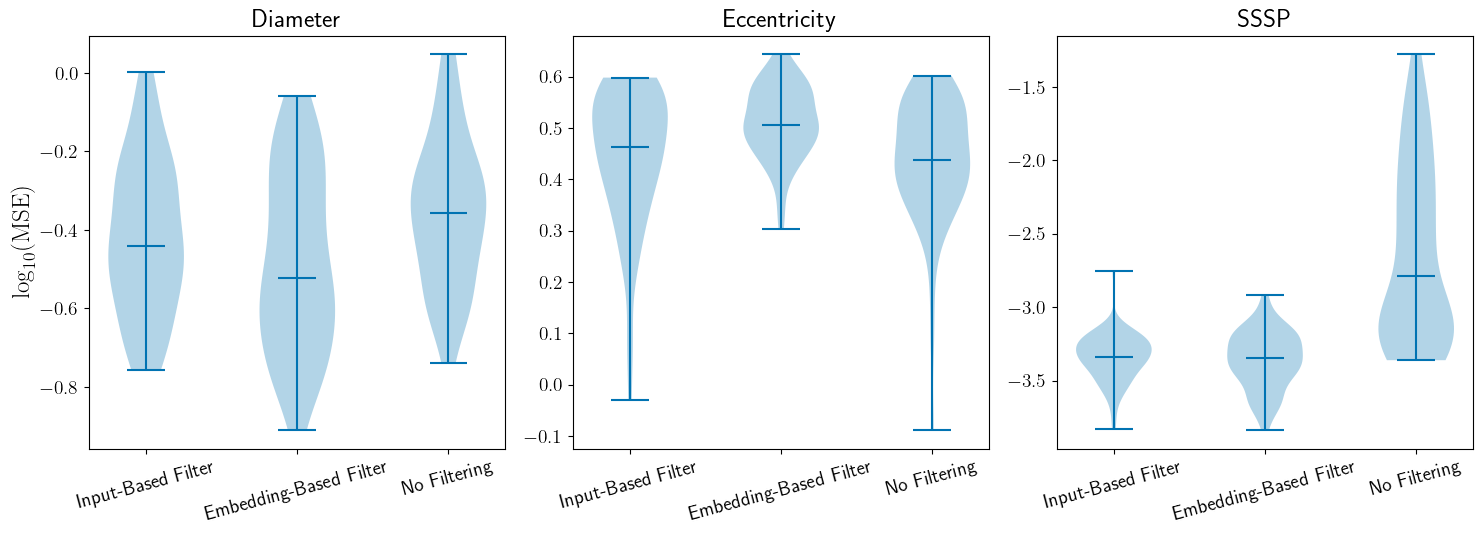

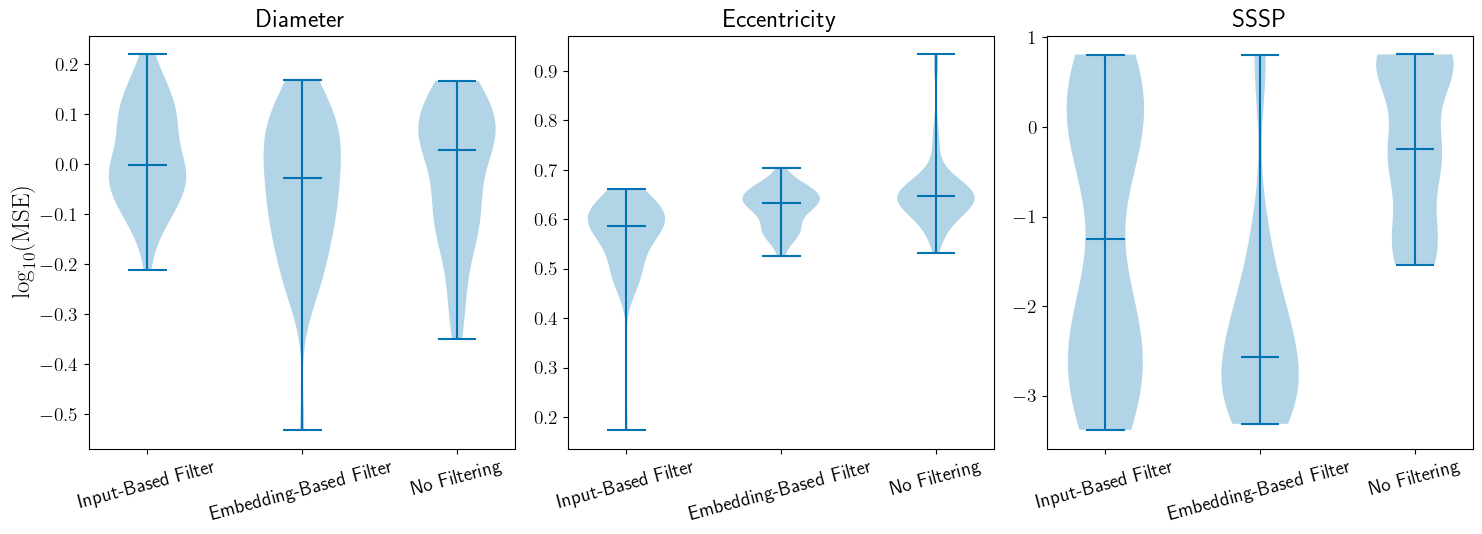

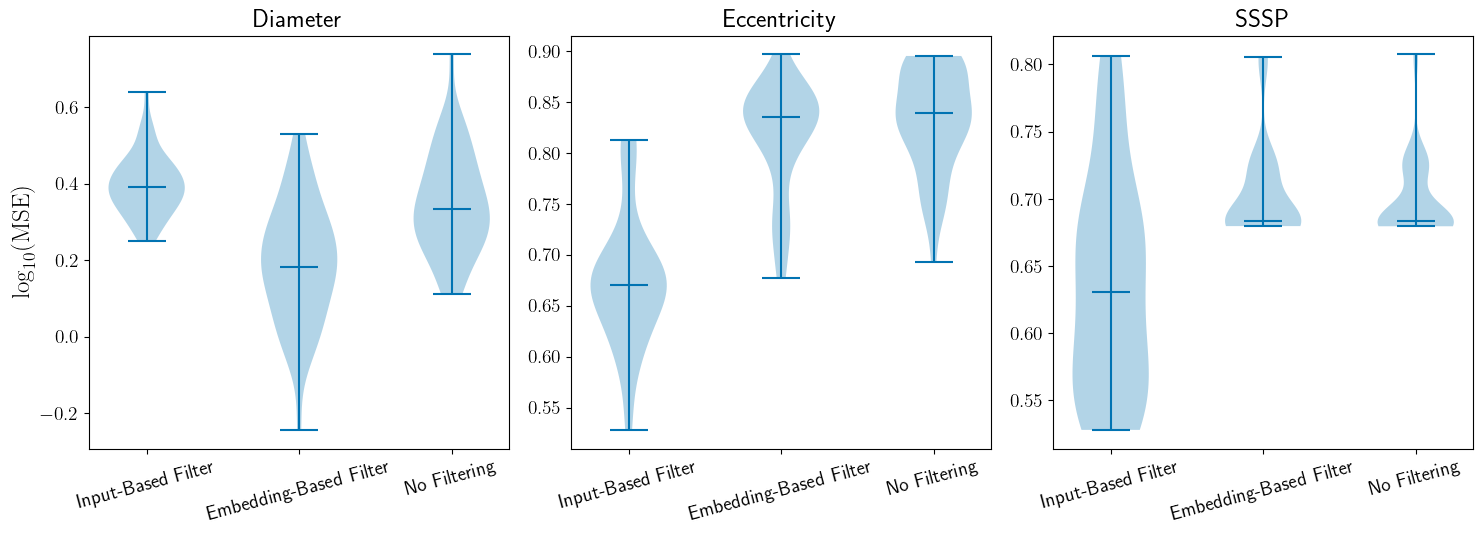

In [70]:
sns.color_palette('colorblind')

file_name='violin_plot'

filter_results = experiment_results.get_filter_results('avg_validation_score')

task_names = [task_name for task_name in filter_results.results_dict]
filter_names = [filter_name for filter_name in filter_results.results_dict[task_names[0]] if filter_name != 'none'] + ['none']

task_names_dict = {}
task_names_dict = {task_name: f'{task}({methods_dict[method1]}+{methods_dict[method2]})' for task_name in task_names for method1, method2, task in [task_name.split('_')]}

tasks = []
methods = []

for task_name in task_names:
    _, method2, task = task_name.split('_')
    if task not in tasks:
        tasks.append(task)
    if method2 not in methods:
        methods.append(method2)
        
task_idx = {'Diameter': 0,
            'Eccentricity': 1,
            'SSSP': 2}
        
for method in methods:

    fig, axs = plt.subplots(1, 3, figsize=(15, 5.5))

    results = {filter_name: {task_name: filter_results.results_dict[task_name][filter_name] for task_name in task_names} for filter_name in filter_names}
    
    for task_name in task_names:
        _, method2, task = task_name.split('_')
        if method2 == method:
            data = [results[filter_name][task_name] for filter_name in filter_names]
            axs[task_idx[task]].violinplot(data, showmedians=True, showextrema=True)
    
    for task in tasks:
        axs[task_idx[task]].set_title(task, **axis_font)
        axs[task_idx[task]].set_xticks([1, 2, 3], [filter_names_dict[filter_name] for filter_name in filter_names], rotation=15)
        axs[task_idx[task]].tick_params(axis='both', which='major', labelsize=font_size)
    
    axs[0].set_ylabel('$\mathrm{log}_{10}(\mathrm{MSE})$', **axis_font)
    
    plt.tight_layout(rect=[0.0, 0.0, 1.0, 1.0])
    fig.patch.set_alpha(0)
    
    new_file_name = file_name + f'_{method}.pdf'
    plot_name = Path(get_plots_path()) / new_file_name
    plt.savefig(plot_name)

Plot results for Peptides-Func and Peptides-Struc:

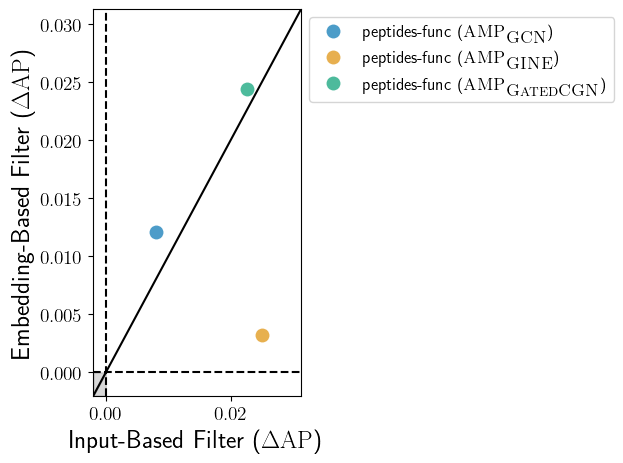

In [20]:
experiment_results = ExperimentResults.load(['udn_gcn_peptides-func', 'udn_gine_peptides-func', 'udn_gatedgcn_peptides-func'],
                                            folder_name='LRGB_RESULTS')

file_name = 'correlation_between_methods_peptides-func'

sns.color_palette('colorblind')

filter_results = experiment_results.get_filter_results('avg_validation_score')

task_names = [task_name for task_name in filter_results.results_dict]
filter_names = [filter_name for filter_name in filter_results.results_dict[task_names[0]] if filter_name != 'none']

task_names_dict = {}
task_names_dict = {task_name: f'{tasks_dict[task]} ({methods_dict[method2]})' for task_name in task_names for method1, method2, task in [task_name.split('_')]}

fig, ax = plt.subplots(1, 1)

results = {filter_name: {task_name: np.max(filter_results.results_dict[task_name][filter_name]) for task_name in task_names} for filter_name in filter_names + ['none']}

max_result = 0.0
min_result = 0.0
alpha = 0.7
markersize = 10

k = 0
for task_name in task_names:
    result_x = results[filter_names[0]][task_name] - results['none'][task_name]
    result_y = results[filter_names[1]][task_name] - results['none'][task_name]
    max_result = np.max([result_x, result_y, max_result])
    min_result = np.min([result_x, result_y, min_result])
    ax.plot(result_x, result_y, 'o', alpha=alpha, label=task_names_dict[task_name], markersize=markersize, markeredgewidth=0.0)
    k += 1

ax.set_xlabel(filter_names_dict[filter_names[0]] + '~($\Delta \mathrm{AP}$)', **axis_font)
ax.set_ylabel(filter_names_dict[filter_names[1]] + '~($\Delta \mathrm{AP}$)', **axis_font)

factor = 1.25
min_result *= factor
max_result *= factor

ax.plot([min_result - 0.002, max_result], [min_result - 0.002, max_result], 'k-')
ax.plot([min_result - 0.002, max_result], [0.0, 0.0], 'k--')
ax.plot([0.0, 0.0], [min_result - 0.002, max_result], 'k--')
ax.fill_between([min_result - 0.002, 0], 0, [min_result - 0.002, 0], color='grey', alpha=0.3)
ax.fill_between([min_result - 0.002, 0], min_result - 0.002, [min_result - 0.002, 0], color='grey', alpha=0.3)

ax.set_xlim(min_result - 0.002, max_result)
ax.set_ylim(min_result - 0.002, max_result)

ax.tick_params(axis='both', which='major', labelsize=font_size)

handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))

plt.legend(handles, labels, bbox_to_anchor=(1.0, 1.0), ncol=1, frameon=True, fontsize=legend_font_size)

plt.tight_layout()
fig.patch.set_alpha(0)

new_file_name = file_name + '.pdf'
plot_name = Path(get_plots_path()) / new_file_name
plt.savefig(plot_name)

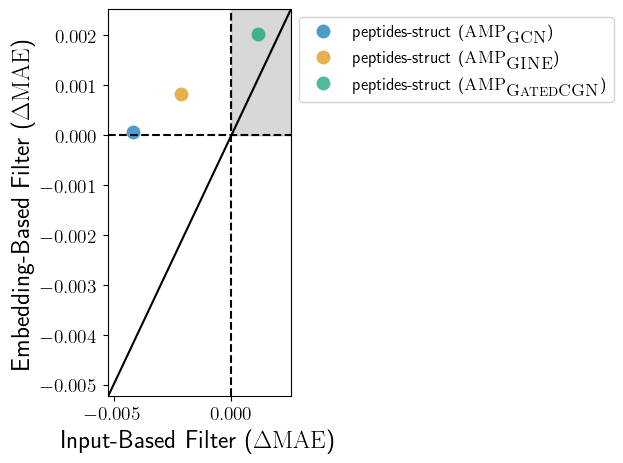

In [19]:
experiment_results = ExperimentResults.load(['udn_gcn_peptides-struct', 'udn_gine_peptides-struct', 'udn_gatedgcn_peptides-struct'],
                                            folder_name='LRGB_RESULTS')

file_name = 'correlation_between_methods_peptides-struct'

sns.color_palette('colorblind')

filter_results = experiment_results.get_filter_results('avg_validation_score')

task_names = [task_name for task_name in filter_results.results_dict]
filter_names = [filter_name for filter_name in filter_results.results_dict[task_names[0]] if filter_name != 'none']

filter_names.reverse()

task_names_dict = {}
task_names_dict = {task_name: f'{tasks_dict[task]} ({methods_dict[method2]})' for task_name in task_names for method1, method2, task in [task_name.split('_')]}

fig, ax = plt.subplots(1, 1)

results = {filter_name: {task_name: np.min(filter_results.results_dict[task_name][filter_name]) for task_name in task_names} for filter_name in filter_names + ['none']}

max_result = 0.0
min_result = 0.0
alpha = 0.7
markersize = 10

k = 0
for task_name in task_names:
    result_x = results[filter_names[0]][task_name] - results['none'][task_name]
    result_y = results[filter_names[1]][task_name] - results['none'][task_name]
    max_result = np.max([result_x, result_y, max_result])
    min_result = np.min([result_x, result_y, min_result])
    ax.plot(result_x, result_y, 'o', alpha=alpha, label=task_names_dict[task_name], markersize=markersize, markeredgewidth=0.0)
    k += 1

ax.set_xlabel(filter_names_dict[filter_names[0]] + '~($\Delta \mathrm{MAE}$)', **axis_font)
ax.set_ylabel(filter_names_dict[filter_names[1]] + '~($\Delta \mathrm{MAE}$)', **axis_font)

factor = 1.25
min_result *= factor
max_result *= factor

ax.plot([min_result, max_result], [min_result, max_result], 'k-')
ax.plot([min_result, max_result], [0.0, 0.0], 'k--')
ax.plot([0.0, 0.0], [min_result, max_result], 'k--')
ax.fill_between([0, max_result], 0, [0, max_result], color='grey', alpha=0.3)
ax.fill_between([0, max_result], max_result, [0, max_result], color='grey', alpha=0.3)

ax.set_xlim(min_result, max_result)
ax.set_ylim(min_result, max_result)

ax.tick_params(axis='both', which='major', labelsize=font_size)

handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))

plt.legend(handles, labels, bbox_to_anchor=(1.0, 1.0), ncol=1, frameon=True, fontsize=legend_font_size)

plt.tight_layout()
fig.patch.set_alpha(0)

new_file_name = file_name + '.pdf'
plot_name = Path(get_plots_path()) / new_file_name
plt.savefig(plot_name)

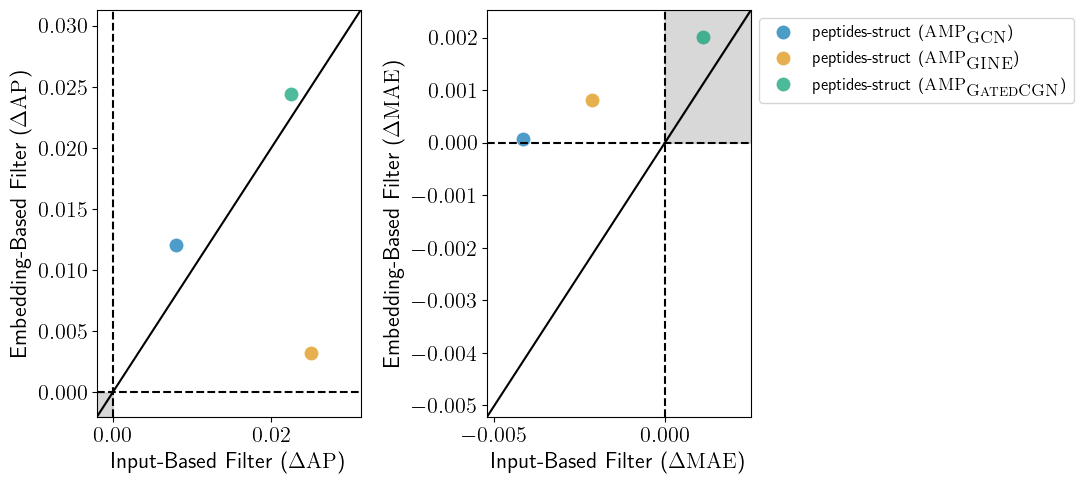

In [34]:
experiment_results = ExperimentResults.load(['udn_gcn_peptides-func', 'udn_gine_peptides-func', 'udn_gatedgcn_peptides-func'],
                                            folder_name='LRGB_RESULTS')

file_name = 'correlation_between_methods_peptides-func'

sns.color_palette('colorblind')

plt.rcParams['font.size'] = 12
axes_font_size = 15
font_size = 16
legend_font_size = 12
axis_font = {'size': axes_font_size}


filter_results = experiment_results.get_filter_results('avg_validation_score')

task_names = [task_name for task_name in filter_results.results_dict]
filter_names = [filter_name for filter_name in filter_results.results_dict[task_names[0]] if filter_name != 'none']

task_names_dict = {}
task_names_dict = {task_name: f'{tasks_dict[task]} ({methods_dict[method2]})' for task_name in task_names for method1, method2, task in [task_name.split('_')]}

fig, ax = plt.subplots(1, 2, figsize=(11,5))

results = {filter_name: {task_name: np.max(filter_results.results_dict[task_name][filter_name]) for task_name in task_names} for filter_name in filter_names + ['none']}

max_result = 0.0
min_result = 0.0
alpha = 0.7
markersize = 10

k = 0
for task_name in task_names:
    result_x = results[filter_names[0]][task_name] - results['none'][task_name]
    result_y = results[filter_names[1]][task_name] - results['none'][task_name]
    max_result = np.max([result_x, result_y, max_result])
    min_result = np.min([result_x, result_y, min_result])
    ax[0].plot(result_x, result_y, 'o', alpha=alpha, label=task_names_dict[task_name], markersize=markersize, markeredgewidth=0.0)
    k += 1

ax[0].set_xlabel(filter_names_dict[filter_names[0]] + '~($\Delta \mathrm{AP}$)', **axis_font)
ax[0].set_ylabel(filter_names_dict[filter_names[1]] + '~($\Delta \mathrm{AP}$)', **axis_font)

factor = 1.25
min_result *= factor
max_result *= factor

ax[0].plot([min_result - 0.002, max_result], [min_result - 0.002, max_result], 'k-')
ax[0].plot([min_result - 0.002, max_result], [0.0, 0.0], 'k--')
ax[0].plot([0.0, 0.0], [min_result - 0.002, max_result], 'k--')
ax[0].fill_between([min_result - 0.002, 0], 0, [min_result - 0.002, 0], color='grey', alpha=0.3)
ax[0].fill_between([min_result - 0.002, 0], min_result - 0.002, [min_result - 0.002, 0], color='grey', alpha=0.3)

ax[0].set_xlim(min_result - 0.002, max_result)
ax[0].set_ylim(min_result - 0.002, max_result)

ax[0].tick_params(axis='both', which='major', labelsize=font_size)

experiment_results = ExperimentResults.load(['udn_gcn_peptides-struct', 'udn_gine_peptides-struct', 'udn_gatedgcn_peptides-struct'],
                                            folder_name='LRGB_RESULTS')

file_name = 'correlation_between_methods_peptides-struct'

filter_results = experiment_results.get_filter_results('avg_validation_score')

task_names = [task_name for task_name in filter_results.results_dict]
filter_names = [filter_name for filter_name in filter_results.results_dict[task_names[0]] if filter_name != 'none']

filter_names.reverse()

task_names_dict = {}
task_names_dict = {task_name: f'{tasks_dict[task]} ({methods_dict[method2]})' for task_name in task_names for method1, method2, task in [task_name.split('_')]}

results = {filter_name: {task_name: np.min(filter_results.results_dict[task_name][filter_name]) for task_name in task_names} for filter_name in filter_names + ['none']}

max_result = 0.0
min_result = 0.0
alpha = 0.7
markersize = 10

k = 0
for task_name in task_names:
    result_x = results[filter_names[0]][task_name] - results['none'][task_name]
    result_y = results[filter_names[1]][task_name] - results['none'][task_name]
    max_result = np.max([result_x, result_y, max_result])
    min_result = np.min([result_x, result_y, min_result])
    ax[1].plot(result_x, result_y, 'o', alpha=alpha, label=task_names_dict[task_name], markersize=markersize, markeredgewidth=0.0)
    k += 1

ax[1].set_xlabel(filter_names_dict[filter_names[0]] + '~($\Delta \mathrm{MAE}$)', **axis_font)
ax[1].set_ylabel(filter_names_dict[filter_names[1]] + '~($\Delta \mathrm{MAE}$)', **axis_font)

factor = 1.25
min_result *= factor
max_result *= factor

ax[1].plot([min_result, max_result], [min_result, max_result], 'k-')
ax[1].plot([min_result, max_result], [0.0, 0.0], 'k--')
ax[1].plot([0.0, 0.0], [min_result, max_result], 'k--')
ax[1].fill_between([0, max_result], 0, [0, max_result], color='grey', alpha=0.3)
ax[1].fill_between([0, max_result], max_result, [0, max_result], color='grey', alpha=0.3)

ax[1].set_xlim(min_result, max_result)
ax[1].set_ylim(min_result, max_result)

ax[1].tick_params(axis='both', which='major', labelsize=font_size)

# handles, labels = ax.get_legend_handles_labels()
# # sort both labels and handles by labels
# labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))

plt.legend(bbox_to_anchor=(1.0, 1.0), ncol=1, frameon=True, fontsize=legend_font_size)

plt.tight_layout()
fig.patch.set_alpha(0)

new_file_name = 'peptides_filter' + '.pdf'
plot_name = Path(get_plots_path()) / new_file_name
plt.savefig(plot_name)